In [13]:
!pip install yfinance

Analisi di cosa succede dopo crolli significativi per S&P 500 (^GSPC) dal 1957
Tentativo di scaricare dati per ^GSPC dal 1957-01-01 al 2025-04-07...
Download riuscito per ^GSPC!
Dati scaricati: 17181 giorni
Periodo: dal 1957-01-02 al 2025-04-04
Colonne disponibili: Close, High, Low, Open, Volume
Usando la colonna '('Close', '^GSPC')' per i calcoli
Trovati 11 crolli settimanali di almeno 7%
Trovati 125 giorni con cali di almeno 3%

--- STATISTICHE CROLLI SETTIMANALE (Soglia: 7%) ---

1 Settimana:
  Media: 2.33%
  Mediana: 4.70%
  Min: -19.47%
  Max: 10.21%
  Rendimenti positivi: 8 su 10 (80.0%)

1 Mese:
  Media: -0.08%
  Mediana: 0.64%
  Min: -14.03%
  Max: 12.32%
  Rendimenti positivi: 5 su 10 (50.0%)

1 Anno:
  Media: 11.42%
  Mediana: 17.95%
  Min: -15.17%
  Max: 40.06%
  Rendimenti positivi: 6 su 10 (60.0%)

Box plot salvato come 'rendimenti_dopo_crolli_settimanale_^GSPC_dal_1957.png'
Box plot per decennio salvato come 'rendimenti_per_decennio_boxplot_settimanale_^GSPC.png'

--- STA

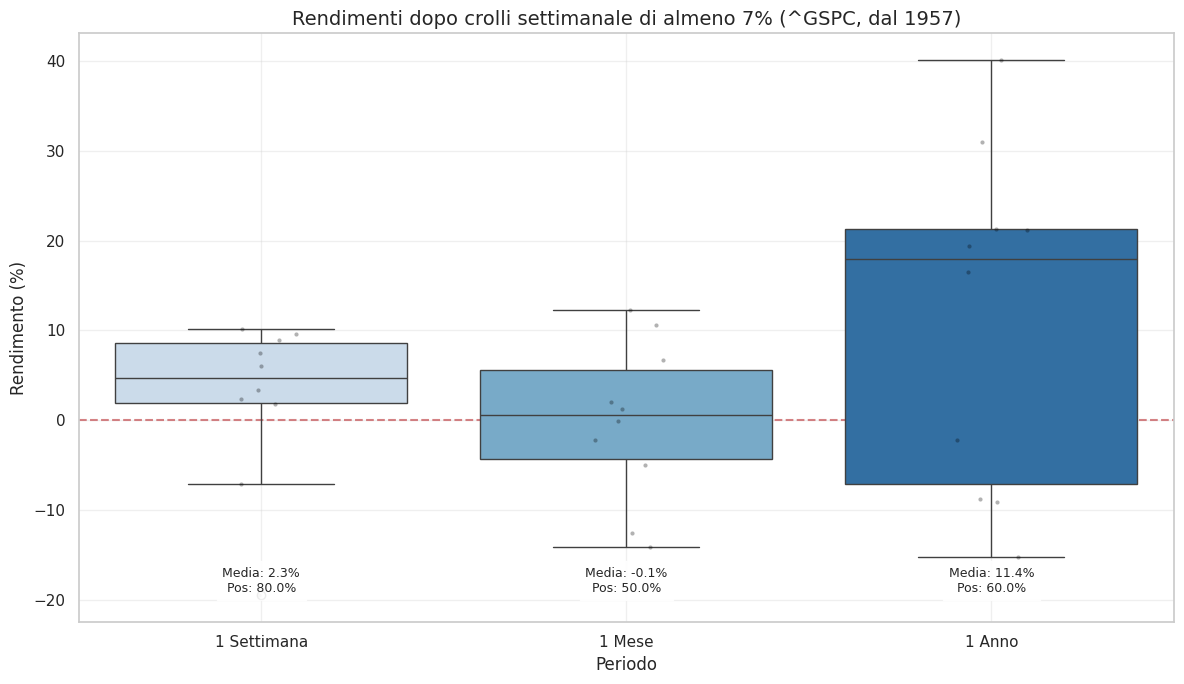

<Figure size 1500x800 with 0 Axes>

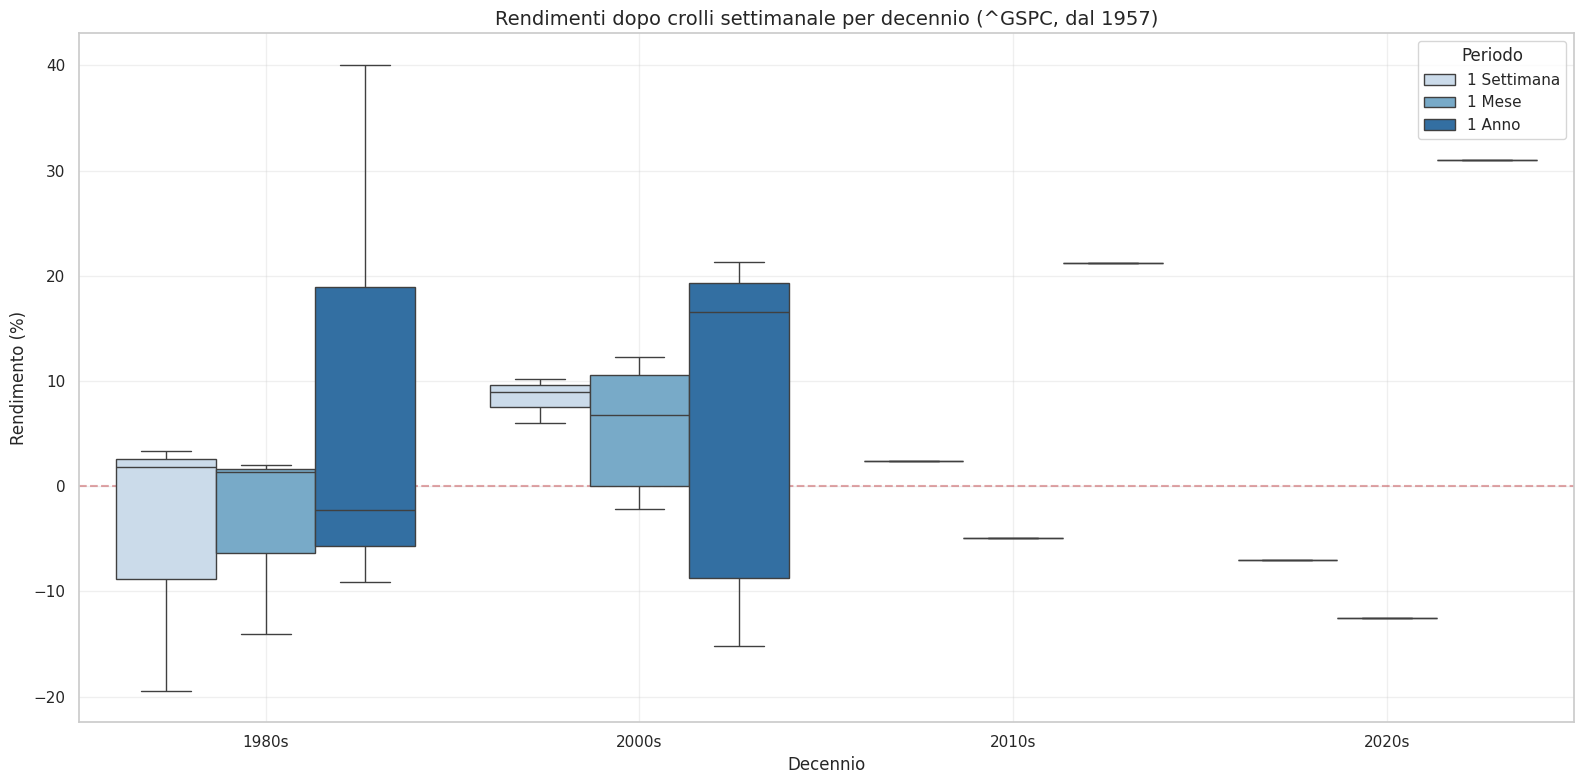

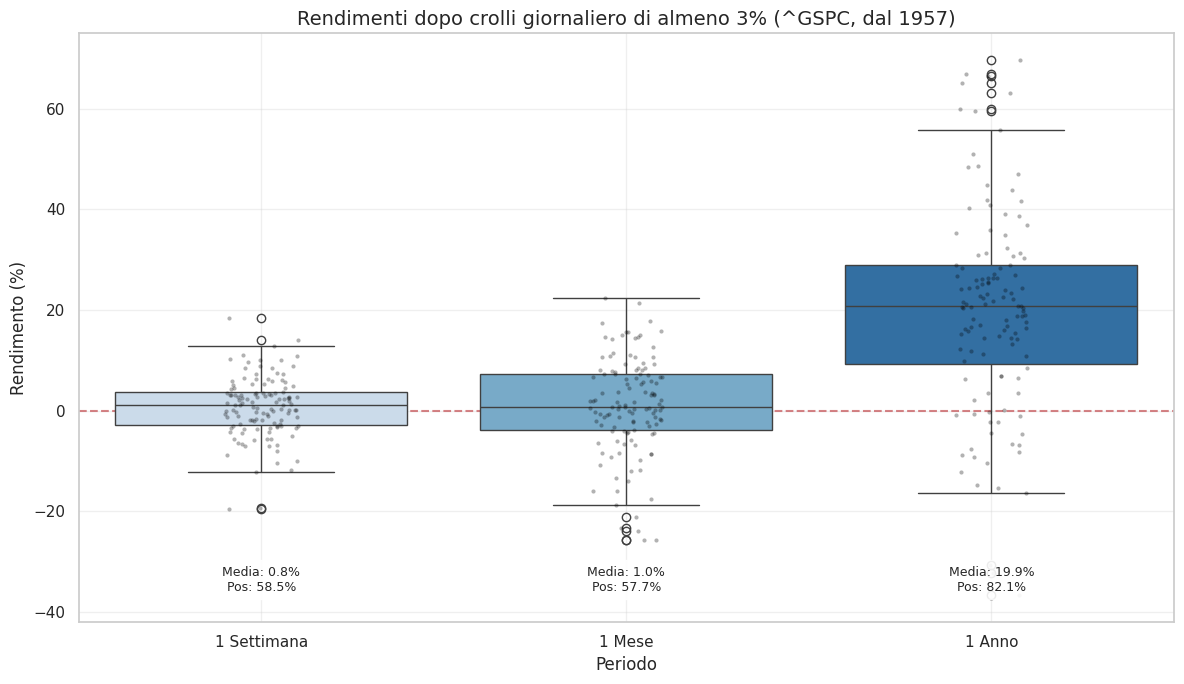

<Figure size 1500x800 with 0 Axes>

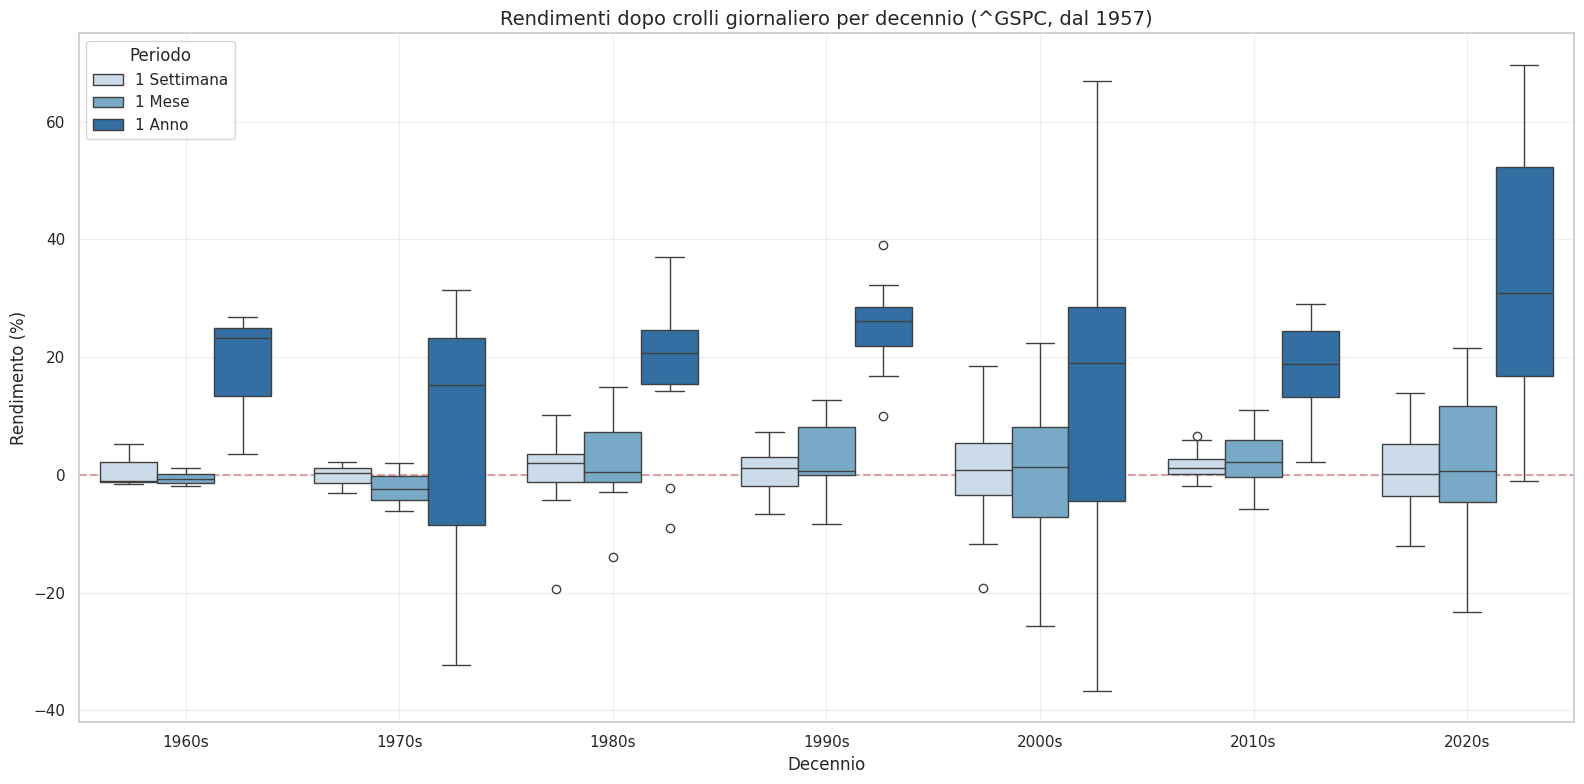

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns

def main():
    """
    Script per analizzare i rendimenti dopo i crolli di mercato dell'S&P 500
    a partire dal 1957 (anno in cui l'S&P 500 ha assunto la sua forma moderna).
    """
    print("Analisi di cosa succede dopo crolli significativi per S&P 500 (^GSPC) dal 1957")

    # Proviamo prima con ^GSPC, se non funziona usiamo SPY come backup
    tickers_to_try = ["^GSPC", "SPY"]
    df = None

    # Data di inizio dal 1957
    inizio = "1957-01-01"
    fine = datetime.now().strftime("%Y-%m-%d")

    for ticker in tickers_to_try:
        try:
            print(f"Tentativo di scaricare dati per {ticker} dal {inizio} al {fine}...")
            temp_df = yf.download(ticker, start=inizio, end=fine, progress=False)

            if not temp_df.empty:
                print(f"Download riuscito per {ticker}!")
                df = temp_df
                current_ticker = ticker
                break
        except Exception as e:
            print(f"Errore nel download di {ticker}: {str(e)}")

    if df is None or df.empty:
        print("Non è stato possibile scaricare i dati per nessuno dei ticker. Uscita.")
        return

    try:
        print(f"Dati scaricati: {len(df)} giorni")
        print(f"Periodo: dal {df.index.min().strftime('%Y-%m-%d')} al {df.index.max().strftime('%Y-%m-%d')}")

        # Gestisci il caso in cui le colonne sono tuple o multi-index
        col_names = []
        for col in df.columns:
            if isinstance(col, tuple):
                col_names.append(str(col[0]))
            else:
                col_names.append(str(col))

        print(f"Colonne disponibili: {', '.join(col_names)}")

        # Step 1: Trova la colonna del prezzo
        price_col = None
        for col in df.columns:
            col_name = col[0] if isinstance(col, tuple) else col
            if col_name == 'Adj Close':
                price_col = col
                break

        # Se 'Adj Close' non esiste, usa 'Close'
        if price_col is None:
            for col in df.columns:
                col_name = col[0] if isinstance(col, tuple) else col
                if col_name == 'Close':
                    price_col = col
                    break

        if price_col is None:
            print("Non è possibile trovare una colonna di prezzo valida.")
            return

        print(f"Usando la colonna '{price_col}' per i calcoli")

        # Calcola i rendimenti settimanali e giornalieri
        df_returns = pd.DataFrame(index=df.index)
        df_returns['Prezzo'] = df[price_col]
        df_returns['Daily_Return'] = df_returns['Prezzo'].pct_change() * 100

        # Calcola il rendimento settimanale
        df_returns['Settimana'] = df_returns.index.to_period('W')
        weekly_returns = df_returns.groupby('Settimana')['Prezzo'].apply(lambda x: (x.iloc[-1] / x.iloc[0] - 1) * 100)
        weekly_returns = weekly_returns.reset_index()
        weekly_returns['Data'] = weekly_returns['Settimana'].apply(lambda x: x.end_time)

        # Analisi cali settimanali (>= 7%)
        soglia_settimanale = -7
        crolli_settimanali = weekly_returns[weekly_returns['Prezzo'] <= soglia_settimanale].copy()

        print(f"Trovati {len(crolli_settimanali)} crolli settimanali di almeno {abs(soglia_settimanale)}%")

        # Analisi cali giornalieri (>= 3%)
        soglia_giornaliera = -3
        crolli_giornalieri = df_returns[df_returns['Daily_Return'] <= soglia_giornaliera].copy()

        print(f"Trovati {len(crolli_giornalieri)} giorni con cali di almeno {abs(soglia_giornaliera)}%")

        # Step 3: Calcola rendimenti dopo i crolli settimanali
        risultati_settimanali = []

        for _, row in crolli_settimanali.iterrows():
            try:
                data_fine_settimana = row['Data']

                # Trova la data nel dataframe giornaliero
                future_dates = df_returns.index[df_returns.index > data_fine_settimana]

                if len(future_dates) < 5:  # Troppo vicino alla fine dei dati
                    continue

                # Prezzo alla fine della settimana del crollo
                prezzo_base = df_returns.loc[df_returns.index <= data_fine_settimana, 'Prezzo'].iloc[-1]

                # 1 settimana dopo
                idx_1w = min(5, len(future_dates) - 1)
                data_1w = future_dates[idx_1w]
                prezzo_1w = df_returns.loc[data_1w, 'Prezzo']
                rendimento_1w = (prezzo_1w / prezzo_base - 1) * 100

                # 1 mese dopo (21 giorni di trading)
                idx_1m = min(21, len(future_dates) - 1)
                data_1m = future_dates[idx_1m]
                prezzo_1m = df_returns.loc[data_1m, 'Prezzo']
                rendimento_1m = (prezzo_1m / prezzo_base - 1) * 100

                # 1 anno dopo (252 giorni di trading)
                idx_1y = min(252, len(future_dates) - 1)
                data_1y = future_dates[idx_1y]
                prezzo_1y = df_returns.loc[data_1y, 'Prezzo']
                rendimento_1y = (prezzo_1y / prezzo_base - 1) * 100

                risultati_settimanali.append({
                    'Data_Crollo': data_fine_settimana,
                    'Calo_Settimanale': row['Prezzo'],
                    'Rendimento_1_Settimana_Dopo': rendimento_1w,
                    'Rendimento_1_Mese_Dopo': rendimento_1m,
                    'Rendimento_1_Anno_Dopo': rendimento_1y
                })
            except Exception as e:
                print(f"Errore per la data settimanale {data_fine_settimana}: {str(e)}")

        # Step 4: Calcola rendimenti dopo i crolli giornalieri
        risultati_giornalieri = []

        for data_crollo in crolli_giornalieri.index:
            try:
                future_dates = df_returns.index[df_returns.index > data_crollo]

                if len(future_dates) < 5:  # Troppo vicino alla fine dei dati
                    continue

                # Prezzo nel giorno del crollo
                prezzo_base = df_returns.loc[data_crollo, 'Prezzo']

                # 1 settimana dopo
                idx_1w = min(5, len(future_dates) - 1)
                data_1w = future_dates[idx_1w]
                prezzo_1w = df_returns.loc[data_1w, 'Prezzo']
                rendimento_1w = (prezzo_1w / prezzo_base - 1) * 100

                # 1 mese dopo (21 giorni di trading)
                idx_1m = min(21, len(future_dates) - 1)
                data_1m = future_dates[idx_1m]
                prezzo_1m = df_returns.loc[data_1m, 'Prezzo']
                rendimento_1m = (prezzo_1m / prezzo_base - 1) * 100

                # 1 anno dopo (252 giorni di trading)
                idx_1y = min(252, len(future_dates) - 1)
                if idx_1y > 0:
                    data_1y = future_dates[idx_1y]
                    prezzo_1y = df_returns.loc[data_1y, 'Prezzo']
                    rendimento_1y = (prezzo_1y / prezzo_base - 1) * 100
                else:
                    rendimento_1y = np.nan

                risultati_giornalieri.append({
                    'Data_Crollo': data_crollo,
                    'Calo_Giornaliero': df_returns.loc[data_crollo, 'Daily_Return'],
                    'Rendimento_1_Settimana_Dopo': rendimento_1w,
                    'Rendimento_1_Mese_Dopo': rendimento_1m,
                    'Rendimento_1_Anno_Dopo': rendimento_1y
                })
            except Exception as e:
                print(f"Errore per la data giornaliera {data_crollo}: {str(e)}")

        # Crea DataFrame con i risultati
        df_risultati_settimanali = pd.DataFrame(risultati_settimanali)
        df_risultati_giornalieri = pd.DataFrame(risultati_giornalieri)

        # Stampa statistiche e fai visualizzazioni
        analizza_e_visualizza(df_risultati_settimanali, 'Settimanale', soglia_settimanale, current_ticker)
        analizza_e_visualizza(df_risultati_giornalieri, 'Giornaliero', soglia_giornaliera, current_ticker)

        # Salva in CSV
        if not df_risultati_settimanali.empty:
            df_risultati_settimanali.to_csv(f'risultati_crolli_settimanali_{current_ticker}_dal_1957.csv', index=False)
            print(f"\nRisultati crolli settimanali salvati in 'risultati_crolli_settimanali_{current_ticker}_dal_1957.csv'")

        if not df_risultati_giornalieri.empty:
            df_risultati_giornalieri.to_csv(f'risultati_crolli_giornalieri_{current_ticker}_dal_1957.csv', index=False)
            print(f"Risultati crolli giornalieri salvati in 'risultati_crolli_giornalieri_{current_ticker}_dal_1957.csv'")

        # Analisi per decennio
        analisi_per_decennio(df_risultati_giornalieri, current_ticker)

        # Stampa le date esatte dei crolli settimanali
        if not df_risultati_settimanali.empty:
            print("\nDate dei crolli settimanali del 7% o più:")
            df_date = df_risultati_settimanali[['Data_Crollo', 'Calo_Settimanale']].sort_values('Data_Crollo')
            df_date['Data_Crollo'] = pd.to_datetime(df_date['Data_Crollo'])
            df_date['Anno'] = df_date['Data_Crollo'].dt.year
            df_date['Mese'] = df_date['Data_Crollo'].dt.month
            df_date['Giorno'] = df_date['Data_Crollo'].dt.day

            for _, row in df_date.iterrows():
                print(f"  {row['Giorno']:02d}/{row['Mese']:02d}/{row['Anno']} - Calo: {row['Calo_Settimanale']:.2f}%")

    except Exception as e:
        print(f"Errore generale: {str(e)}")
        import traceback
        traceback.print_exc()

def analizza_e_visualizza(df_risultati, tipo, soglia, ticker):
    """
    Analizza e visualizza i risultati usando box plot.
    """
    if df_risultati.empty:
        print(f"\nNessun risultato disponibile per l'analisi {tipo.lower()}.")
        return

    print(f"\n--- STATISTICHE CROLLI {tipo.upper()} (Soglia: {abs(soglia)}%) ---")
    for colonna in ['Rendimento_1_Settimana_Dopo', 'Rendimento_1_Mese_Dopo', 'Rendimento_1_Anno_Dopo']:
        valori = df_risultati[colonna].dropna()

        if len(valori) == 0:
            continue

        media = valori.mean()
        mediana = valori.median()
        min_val = valori.min()
        max_val = valori.max()
        positivi = (valori > 0).sum()
        perc_positivi = positivi / len(valori) * 100

        periodo = colonna.replace('Rendimento_', '').replace('_Dopo', '').replace('_', ' ')

        print(f"\n{periodo}:")
        print(f"  Media: {media:.2f}%")
        print(f"  Mediana: {mediana:.2f}%")
        print(f"  Min: {min_val:.2f}%")
        print(f"  Max: {max_val:.2f}%")
        print(f"  Rendimenti positivi: {positivi} su {len(valori)} ({perc_positivi:.1f}%)")

    # Crea visualizzazioni
    try:
        # 1. Box plot
        plt.figure(figsize=(12, 7))
        sns.set(style="whitegrid")

        periodi = ['Rendimento_1_Settimana_Dopo', 'Rendimento_1_Mese_Dopo', 'Rendimento_1_Anno_Dopo']
        etichette = ['1 Settimana', '1 Mese', '1 Anno']

        # Creiamo un DataFrame per seaborn
        box_data = pd.DataFrame()
        for col, label in zip(periodi, etichette):
            temp_df = pd.DataFrame({
                'Periodo': label,
                'Rendimento': df_risultati[col].dropna()
            })
            box_data = pd.concat([box_data, temp_df])

        # Plot
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)

        # Boxplot con punti per i singoli valori
        sns.boxplot(x='Periodo', y='Rendimento', data=box_data, hue='Periodo', palette='Blues', legend=False)
        sns.stripplot(x='Periodo', y='Rendimento', data=box_data, color='black', size=3, alpha=0.3)

        plt.title(f'Rendimenti dopo crolli {tipo.lower()} di almeno {abs(soglia)}% ({ticker}, dal 1957)', fontsize=14)
        plt.ylabel('Rendimento (%)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Aggiungi statistiche al grafico
        for i, label in enumerate(etichette):
            subset = box_data[box_data['Periodo'] == label]
            if not subset.empty:
                media = subset['Rendimento'].mean()
                positivi = (subset['Rendimento'] > 0).sum() / len(subset) * 100
                plt.text(i, plt.ylim()[0] * 0.85, f'Media: {media:.1f}%\nPos: {positivi:.1f}%',
                         ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.9))

        plt.tight_layout()
        plt.savefig(f'rendimenti_dopo_crolli_{tipo.lower()}_{ticker}_dal_1957.png', dpi=300)
        print(f"\nBox plot salvato come 'rendimenti_dopo_crolli_{tipo.lower()}_{ticker}_dal_1957.png'")

        # 2. Grafico cronologico con box plot per decennio
        plt.figure(figsize=(15, 8))

        df_temp = df_risultati.copy()
        df_temp['Data_Crollo'] = pd.to_datetime(df_temp['Data_Crollo'])
        df_temp['Decennio'] = (df_temp['Data_Crollo'].dt.year // 10) * 10

        # Ordina per rendimento a 1 anno
        decenni = sorted(df_temp['Decennio'].unique())

        # Crea un DataFrame per il box plot per decennio (solo rendimento a 1 anno)
        boxplot_data_decennio = pd.DataFrame()
        for decennio in decenni:
            temp = df_temp[df_temp['Decennio'] == decennio]
            if not temp.empty:
                for col, label in zip(periodi, etichette):
                    periodo_df = pd.DataFrame({
                        'Decennio': f"{decennio}s",
                        'Periodo': label,
                        'Rendimento': temp[col].dropna()
                    })
                    boxplot_data_decennio = pd.concat([boxplot_data_decennio, periodo_df])

        if not boxplot_data_decennio.empty:
            # Box plot per decennio
            plt.figure(figsize=(16, 8))
            plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

            # Usa catplot per avere facet grid
            g = sns.boxplot(x='Decennio', y='Rendimento', hue='Periodo', data=boxplot_data_decennio,
                           palette='Blues', showfliers=True)

            plt.title(f'Rendimenti dopo crolli {tipo.lower()} per decennio ({ticker}, dal 1957)', fontsize=14)
            plt.ylabel('Rendimento (%)', fontsize=12)
            plt.xlabel('Decennio', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend(title="Periodo")

            plt.tight_layout()
            plt.savefig(f'rendimenti_per_decennio_boxplot_{tipo.lower()}_{ticker}.png', dpi=300)
            print(f"Box plot per decennio salvato come 'rendimenti_per_decennio_boxplot_{tipo.lower()}_{ticker}.png'")

    except Exception as e:
        print(f"Errore nella creazione dei grafici {tipo.lower()}: {str(e)}")

def analisi_per_decennio(df_risultati, ticker):
    """
    Analizza i rendimenti per decennio.
    """
    if df_risultati.empty:
        return

    try:
        print("\n--- ANALISI PER DECENNIO ---")

        df_temp = df_risultati.copy()
        df_temp['Data_Crollo'] = pd.to_datetime(df_temp['Data_Crollo'])
        df_temp['Decennio'] = (df_temp['Data_Crollo'].dt.year // 10) * 10

        # Aggiungi il periodo
        periodi = ['Rendimento_1_Settimana_Dopo', 'Rendimento_1_Mese_Dopo', 'Rendimento_1_Anno_Dopo']
        etichette = ['1 Settimana', '1 Mese', '1 Anno']

        # Statistiche per decennio
        decenni_stats = {}
        for decennio in sorted(df_temp['Decennio'].unique()):
            decenni_stats[decennio] = {}
            subset = df_temp[df_temp['Decennio'] == decennio]

            for periodo, etichetta in zip(periodi, etichette):
                valori = subset[periodo].dropna()
                if len(valori) > 0:
                    media = valori.mean()
                    mediana = valori.median()
                    positivi = (valori > 0).sum() / len(valori) * 100
                    decenni_stats[decennio][etichetta] = {
                        'media': media,
                        'mediana': mediana,
                        'positivi': positivi,
                        'conteggio': len(valori)
                    }

        # Tabella
        print("\nRendimenti medi per decennio:")
        header = "Decennio | Conteggio | 1 Settimana | 1 Mese | 1 Anno"
        separatore = "-" * len(header)
        print(separatore)
        print(header)
        print(separatore)

        for decennio in sorted(decenni_stats.keys()):
            stats = decenni_stats[decennio]
            conteggio = stats.get('1 Settimana', {}).get('conteggio', 0)
            sett = stats.get('1 Settimana', {}).get('media', float('nan'))
            mese = stats.get('1 Mese', {}).get('media', float('nan'))
            anno = stats.get('1 Anno', {}).get('media', float('nan'))

            print(f"{decennio}s | {conteggio:8d} | {sett:10.2f}% | {mese:6.2f}% | {anno:5.2f}%")

        print(separatore)

        # Tabella delle mediane
        print("\nRendimenti mediani per decennio:")
        header = "Decennio | Conteggio | 1 Settimana | 1 Mese | 1 Anno"
        separatore = "-" * len(header)
        print(separatore)
        print(header)
        print(separatore)

        for decennio in sorted(decenni_stats.keys()):
            stats = decenni_stats[decennio]
            conteggio = stats.get('1 Settimana', {}).get('conteggio', 0)
            sett = stats.get('1 Settimana', {}).get('mediana', float('nan'))
            mese = stats.get('1 Mese', {}).get('mediana', float('nan'))
            anno = stats.get('1 Anno', {}).get('mediana', float('nan'))

            print(f"{decennio}s | {conteggio:8d} | {sett:10.2f}% | {mese:6.2f}% | {anno:5.2f}%")

        print(separatore)

        # Tabella percentuale rendimenti positivi
        print("\nPercentuale rendimenti positivi per decennio:")
        header = "Decennio | Conteggio | 1 Settimana | 1 Mese | 1 Anno"
        separatore = "-" * len(header)
        print(separatore)
        print(header)
        print(separatore)

        for decennio in sorted(decenni_stats.keys()):
            stats = decenni_stats[decennio]
            conteggio = stats.get('1 Settimana', {}).get('conteggio', 0)
            sett = stats.get('1 Settimana', {}).get('positivi', float('nan'))
            mese = stats.get('1 Mese', {}).get('positivi', float('nan'))
            anno = stats.get('1 Anno', {}).get('positivi', float('nan'))

            print(f"{decennio}s | {conteggio:8d} | {sett:10.1f}% | {mese:6.1f}% | {anno:5.1f}%")

        print(separatore)

    except Exception as e:
        print(f"Errore nell'analisi per decennio: {str(e)}")

if __name__ == "__main__":
    main()